## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [114]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import regex as re
import warnings
warnings.filterwarnings("ignore")

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
# Check the info of the columns of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [12]:
# Look at the sub issues columns
df[["_source.sub_issue", "_source.issue"]]

,_source.sub_issue,_source.issue
0,Debt is not yours,Attempts to collect debt not owed
1,Didn't receive enough information to verify debt,Written notification about debt
2,Problem with rewards from credit card,"Other features, terms, or problems"
3,None,Trouble during payment process
4,Charged too much interest,Fees or interest
...,...,...
78308,Funds not received from closed account,Closing an account
78309,Other problem,"Other features, terms, or problems"
78310,Transaction was not authorized,Problem with a lender or other company chargin...
78311,Problem with balance transfer,"Other features, terms, or problems"


In [13]:
# Check the distinct number of values in columns
df.nunique()

_index                                   1
_type                                    1
_id                                  78313
_score                                   1
_source.tags                             3
_source.zip_code                      9442
_source.complaint_id                 78313
_source.issue                          154
_source.date_received                 3444
_source.state                           62
_source.consumer_disputed                3
_source.product                         17
_source.company_response                 8
_source.company                          1
_source.submitted_via                    6
_source.date_sent_to_company          3309
_source.company_public_response          3
_source.sub_product                     72
_source.timely                           2
_source.complaint_what_happened      20931
_source.sub_issue                      205
_source.consumer_consent_provided        5
dtype: int64

In [18]:
# Function to label the count on top of each bar in graph
def label_values(ax, spacing=5):
    total = 0
    for rect in ax.patches:
        total += rect.get_height()

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        
        va = 'bottom'
        
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.2f}, {:.2f}".format(y_value, y_value/total*100)
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha='center',                
            va=va)    

In [19]:
# Get the column names
column_names = list(df.nunique().index)

In [20]:
# Get the unique values in columns
column_unique_values = list(df.nunique())

In [21]:
var_categorical = [column_names[x] for x in range(len(column_names)) if column_unique_values[x]<10]

In [22]:
# Categorical column names
var_categorical

['_index',
 '_type',
 '_score',
 '_source.tags',
 '_source.consumer_disputed',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.company_public_response',
 '_source.timely',
 '_source.consumer_consent_provided']

_Index


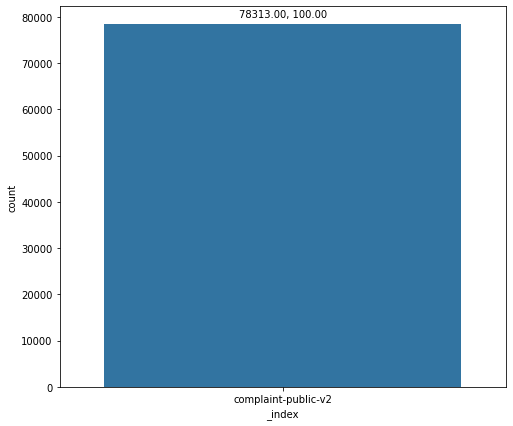

_Type


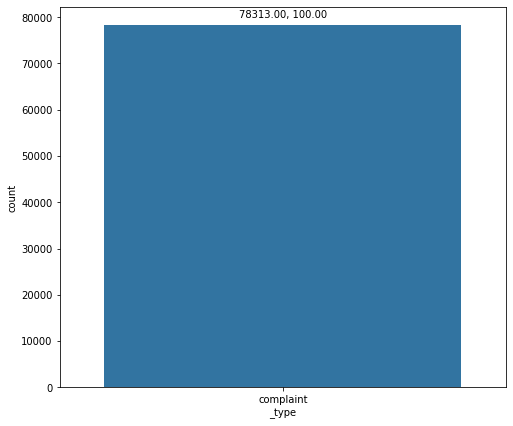

_Score


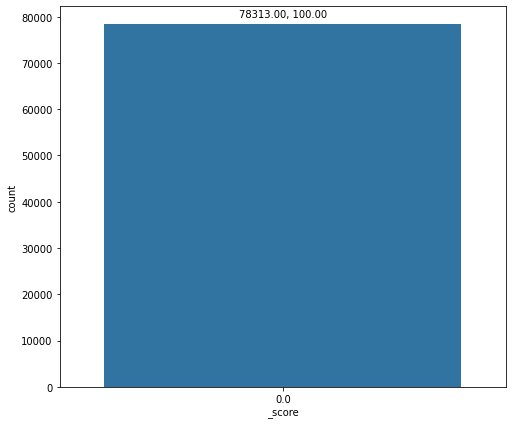

_Source.Tags


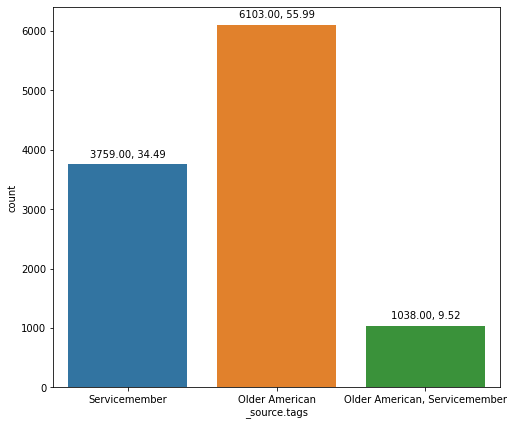

_Source.Consumer_Disputed


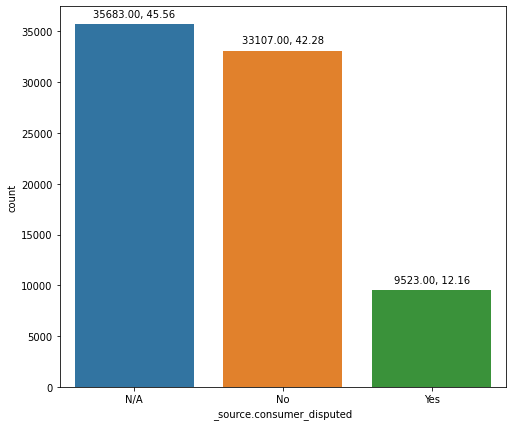

_Source.Company_Response


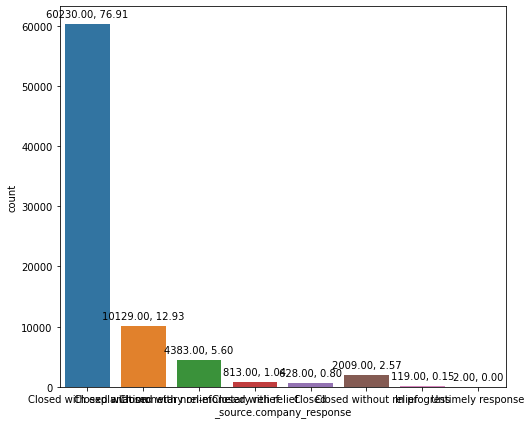

_Source.Company


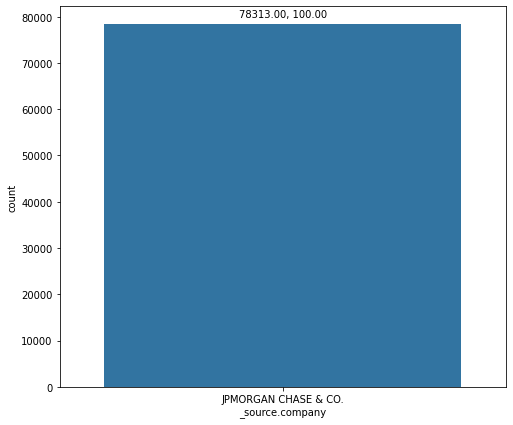

_Source.Submitted_Via


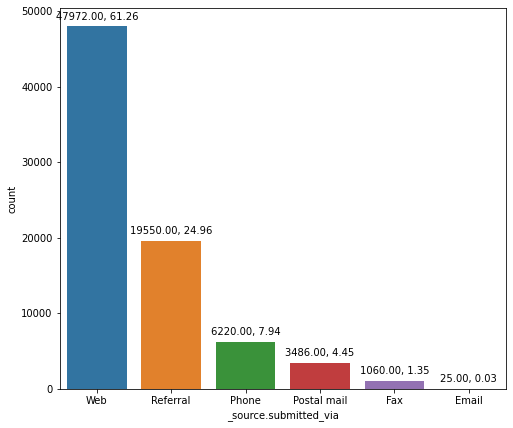

_Source.Company_Public_Response


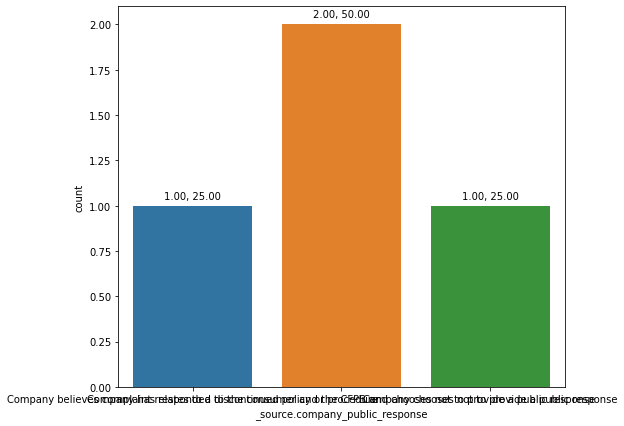

_Source.Timely


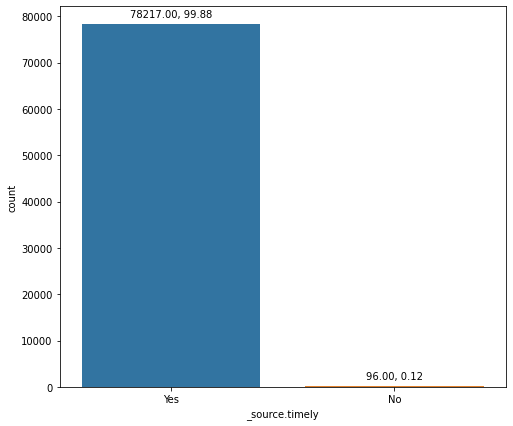

_Source.Consumer_Consent_Provided


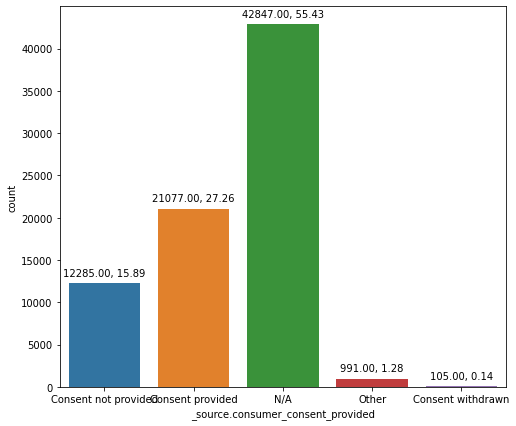

In [23]:
# Countplot for each categorical variable
for column in var_categorical:
    print(column.title())
    plt.figure(figsize=(8, 7))
    ax = sns.countplot(x = df[column])
    label_values(ax)
    plt.show()

In [24]:
#Assign new column names
df.columns = ["index","type","id","score","tags","zip_code","complaint_id","issue","date_received","state","consumer_disputed","product","company_response","company","submitted_via","date_sent_to_company","company_public_response","sub_product","timely","complaint_what_happened","sub_issue","consumer_consent_provided"]

In [25]:
len(df[df["complaint_what_happened"]==""])

57241

In [26]:
# Assigning nan in place of blanks in the complaints column(complaint_what_happened)
df["complaint_what_happened"] = df["complaint_what_happened"].replace(r'^\s*$', np.nan, regex=True)

In [27]:
df["complaint_what_happened"].isnull().sum()

57241

In [28]:
#Remove all rows where complaints column is nan
df = df[df["complaint_what_happened"].notnull()]

In [29]:
len(df["complaint_what_happened"])

21072

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [30]:
# Write your function here to clean the text and remove all the unnecessary elements.
def preprocessing(sent, remove_text_in_brackets = True, remove_punctuation = True, remove_word_with_numbers = True):
    sent = sent.lower()
    if remove_text_in_brackets:
        sent = re.sub("\[.*?\]", "", sent)
    if remove_punctuation:
        sent = re.sub("[^\w\s]", "", sent)
    if remove_word_with_numbers:
        sent = re.sub("\w*\d\w*\s", "", sent)
    return sent.strip()

In [31]:
#Write your function to Lemmatize the texts
import spacy 
nlp = spacy.load("en_core_web_sm")

def lemmatize(sent):
    return_sent = []
    doc = nlp(sent)
    for word in doc:
        return_sent.append(word.lemma_)
    return " ".join(return_sent)

In [32]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = pd.DataFrame({
    "complaint_what_happened": list(map(preprocessing, df["complaint_what_happened"]))
})

In [33]:
# Create column in df_clean for 'Lemmatized Complaints'
df_clean["Lemmatized_Complaints"] = list(map(lemmatize, df_clean["complaint_what_happened"]))

In [34]:
df_clean.head()

,complaint_what_happened,Lemmatized_Complaints
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
1,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
3,on while trying to book a xxxx xxxx ticket i...,on while try to book a xxxx xxxx ticket I ...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...


In [35]:
#Write your function to extract the POS tags 

def pos_tag(sent):
    return_sent = []
    doc = nlp(sent)
    for word in doc:
#         print(word.pos_)
        if word.pos_ == "NOUN":
            return_sent.append(word.text)
    return " ".join(return_sent)

In [36]:
# The clean dataframe now contain the complaint after removing POS tags.
df_clean["POS_Removed_Complaints"]  = list(map(pos_tag, df_clean["Lemmatized_Complaints"]))

In [37]:
df_clean.head()

,complaint_what_happened,Lemmatized_Complaints,POS_Removed_Complaints
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop debt verification state...
1,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,xxxx xxxx card agent anniversary date agent in...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase report application identity consent serv...
3,on while trying to book a xxxx xxxx ticket i...,on while try to book a xxxx xxxx ticket I ...,while xxxx ticket offer ticket reward card inf...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank close accoun...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




/home/zyper26/anaconda3/envs/tf22/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



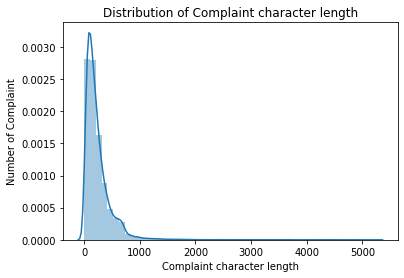

In [38]:
# Code here to visualise the data according to the 'Complaint' character length

sns.distplot(df_clean["complaint_what_happened"] .apply(lambda x: len(x.split())))
plt.title('Distribution of Complaint character length')
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
plt.show()

/home/zyper26/anaconda3/envs/tf22/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



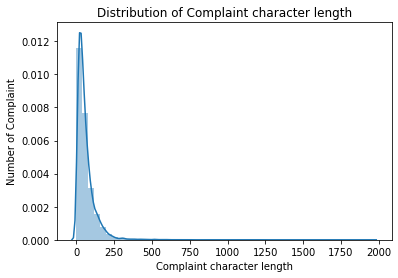

In [39]:
# Code here to visualise the data according to the 'Complaints after removing POS tags' character length

sns.distplot(df_clean["POS_Removed_Complaints"] .apply(lambda x: len(x.split())))
plt.title('Distribution of Complaint character length')
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

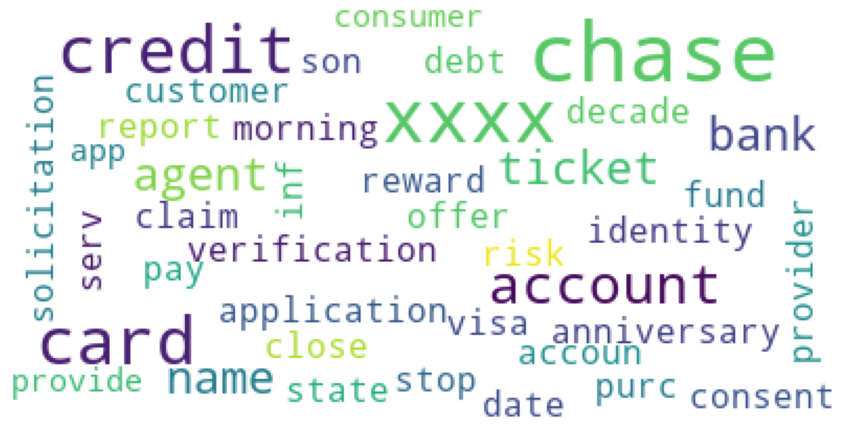

In [40]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
plt.figure(figsize=(15, 16))

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['POS_Removed_Complaints']))


fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [41]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['POS_Removed_Complaints'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [42]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_30_gram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1,1), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [43]:
#Print the top 10 words in the unigram frequency
top_30_unigram = get_top_30_gram(df_clean["Complaint_clean"], n=30)
print(top_30_unigram)

[('xxxx', 138050), ('chase', 54258), ('account', 47237), ('credit', 33394), ('card', 29639), ('payment', 21164), ('bank', 20310), ('time', 16018), ('xxxxxxxx', 14509), ('charge', 14506), ('day', 12958), ('money', 11937), ('check', 11363), ('loan', 10886), ('information', 9649), ('letter', 9606), ('fee', 8882), ('report', 8851), ('transaction', 8648), ('number', 8618), ('month', 8436), ('year', 8271), ('customer', 8163), ('mortgage', 8082), ('balance', 7739), ('company', 7615), ('phone', 7615), ('service', 7514), ('state', 7336), ('claim', 7263)]


In [44]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_10_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [45]:
#Print the top 10 words in the bigram frequency
top_10_bigram = get_top_10_bigram(df_clean["Complaint_clean"], n=10)
print(top_10_bigram)

[('xxxx xxxx', 64193), ('credit card', 12677), ('credit report', 3966), ('xxxx chase', 3609), ('customer service', 3079), ('account xxxx', 2964), ('chase credit', 2927), ('account chase', 2861), ('xxxx account', 2680), ('chase account', 2624)]


In [46]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_10_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [47]:
#Print the top 10 words in the trigram frequency
top_10_trigram = get_top_10_trigram(df_clean["Complaint_clean"], n=10)
print(top_10_trigram)

[('xxxx xxxx xxxx', 33836), ('chase credit card', 1938), ('xxxx xxxx chase', 1567), ('account xxxx xxxx', 1209), ('credit card account', 1098), ('xxxx xxxx account', 1069), ('credit card company', 987), ('xxxx credit card', 946), ('xxxxxxxx xxxx xxxx', 916), ('chase xxxx xxxx', 896)]


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [48]:
# Remove 'xxxx' for each complaints
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [49]:
#All masked texts has been removed
df_clean

,complaint_what_happened,Lemmatized_Complaints,POS_Removed_Complaints,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop debt verification state...,morning name stop debt verification statement...
1,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,xxxx xxxx card agent anniversary date agent in...,card agent anniversary date agent informatio...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase report application identity consent serv...,chase report application identity consent serv...
3,on while trying to book a xxxx xxxx ticket i...,on while try to book a xxxx xxxx ticket I ...,while xxxx ticket offer ticket reward card inf...,while ticket offer ticket reward card informa...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank close accoun...,son chase account fund chase bank close accoun...
...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx xxxx visa credit card provider claim purc...,visa credit card provider claim purchase pro...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer chase bank app chase...,pay risk provide consumer chase bank app chase...
21070,i have had flawless credit for yrs ive had cha...,I have have flawless credit for yr I ve have c...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [52]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = vectorizer.fit_transform(df_clean["Complaint_clean"])

pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

,16,17,18,19,20,aa,aaarating,aarp,ab,aba,...,youinv,yours,youth,yr,yrs,ytd,zip,zipcode,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.145064,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [53]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [54]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [55]:
# Fit on NMF and get the number of vectorizer feature names
nmf_model.fit(X)
len(vectorizer.get_feature_names())

/home/zyper26/anaconda3/envs/tf22/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



6955

In [56]:
#Print the Top15 words for each of the topics
words = np.array(vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 10)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(10)]).astype(str)
for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:10]
    topic_words.iloc[i] = words[ix]

print(topic_words)

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,account,check,bank,money,chase,fund,deposit,branch,day,checking
Topic 2,credit,report,card,inquiry,account,score,chase,company,debt,information
Topic 3,payment,balance,interest,month,fee,statement,amount,day,time,bill
Topic 4,charge,card,chase,dispute,transaction,fee,purchase,fraud,merchant,claim
Topic 5,loan,mortgage,chase,home,modification,property,year,letter,document,time


In [57]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
W = nmf_model.transform(X)
W = W.argmax(axis = 1)
W

array([4, 3, 1, ..., 3, 2, 2])

In [58]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W

In [59]:
df_clean.head()

,complaint_what_happened,Lemmatized_Complaints,POS_Removed_Complaints,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop debt verification state...,morning name stop debt verification statement...,4
1,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,xxxx xxxx card agent anniversary date agent in...,card agent anniversary date agent informatio...,3
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase report application identity consent serv...,chase report application identity consent serv...,1
3,on while trying to book a xxxx xxxx ticket i...,on while try to book a xxxx xxxx ticket I ...,while xxxx ticket offer ticket reward card inf...,while ticket offer ticket reward card informa...,1
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank close accoun...,son chase account fund chase bank close accoun...,0


In [60]:
#Print the first 5 Complaint for each of the Topics

df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaint_what_happened,Lemmatized_Complaints,POS_Removed_Complaints,Complaint_clean,Topic
12,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account code xxxx bonus xxxxxxxx term account ...,account code bonus term account deposit bon...,0
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank close accoun...,son chase account fund chase bank close accoun...,0
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice jp account debit card branch customer s...,notice jp account debit card branch customer s...,0
15,i opened the saving account for the bonus i wa...,I open the save account for the bonus I be sup...,save account bonus bonus auto transfer check t...,save account bonus bonus auto transfer check t...,0
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase report application identity consent serv...,chase report application identity consent serv...,1
3,on while trying to book a xxxx xxxx ticket i...,on while try to book a xxxx xxxx ticket I ...,while xxxx ticket offer ticket reward card inf...,while ticket offer ticket reward card informa...,1
5,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
9,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,credit card datum credit report company issue,credit card datum credit report company issue,1
11,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...,xxxx time attempt inquiry remove creditor inqu...,time attempt inquiry remove creditor inquiry ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [61]:
df_test = df_clean.copy(deep=True)

In [67]:
# Dictionary of Topic names and Topics based on the values of topic_words

Topic_names = { 
    0 : 'Bank Account services',
    1 : 'Credit card or prepaid card',
    3 : 'Theft/Dispute Reporting',
    4 : 'Mortgage/Loan',
    2 : 'Others'
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [68]:
df_clean

,complaint_what_happened,Lemmatized_Complaints,POS_Removed_Complaints,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop debt verification state...,morning name stop debt verification statement...,Mortgage/Loan
1,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,xxxx xxxx card agent anniversary date agent in...,card agent anniversary date agent informatio...,Theft/Dispute Reporting
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase report application identity consent serv...,chase report application identity consent serv...,Credit card or prepaid card
3,on while trying to book a xxxx xxxx ticket i...,on while try to book a xxxx xxxx ticket I ...,while xxxx ticket offer ticket reward card inf...,while ticket offer ticket reward card informa...,Credit card or prepaid card
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank close accoun...,son chase account fund chase bank close accoun...,Bank Account services
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Theft/Dispute Reporting
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx xxxx visa credit card provider claim purc...,visa credit card provider claim purchase pro...,Theft/Dispute Reporting
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer chase bank app chase...,pay risk provide consumer chase bank app chase...,Theft/Dispute Reporting
21070,i have had flawless credit for yrs ive had cha...,I have have flawless credit for yr I ve have c...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [69]:
df_test = df_clean.copy(deep=True)

In [70]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 
    'Bank Account services' : 0,
    'Credit card or prepaid card' : 1,
    'Theft/Dispute Reporting' : 3,
    'Mortgage/Loan' : 4,
    'Others' : 2 
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [71]:
df_clean

,complaint_what_happened,Lemmatized_Complaints,POS_Removed_Complaints,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop debt verification state...,morning name stop debt verification statement...,4
1,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,xxxx xxxx card agent anniversary date agent in...,card agent anniversary date agent informatio...,3
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase report application identity consent serv...,chase report application identity consent serv...,1
3,on while trying to book a xxxx xxxx ticket i...,on while try to book a xxxx xxxx ticket I ...,while xxxx ticket offer ticket reward card inf...,while ticket offer ticket reward card informa...,1
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank close accoun...,son chase account fund chase bank close accoun...,0
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,3
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx xxxx visa credit card provider claim purc...,visa credit card provider claim purchase pro...,3
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer chase bank app chase...,pay risk provide consumer chase bank app chase...,3
21070,i have had flawless credit for yrs ive had cha...,I have have flawless credit for yr I ve have c...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,2


In [72]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaint_what_happened", "Topic"]]

In [73]:
training_data

,complaint_what_happened,Topic
0,good morning my name is xxxx xxxx and i apprec...,4
1,i upgraded my xxxx xxxx card in and was told b...,3
2,chase card was reported on however fraudulent ...,1
3,on while trying to book a xxxx xxxx ticket i...,1
4,my grand son give me check for i deposit it in...,0
...,...,...
21067,after being a chase card customer for well ove...,3
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,3
21069,i am not familiar with xxxx pay and did not un...,3
21070,i have had flawless credit for yrs ive had cha...,2


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [148]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [160]:
#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint_what_happened)

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
# Split train and test data 
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data["Topic"], test_size=0.25, random_state=42)

In [100]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

In [109]:
# Function to get the confusion matrix, classification report and the accuracy score of the predictions
def get_report(predicted):
    confusion_mat = confusion_matrix(y_test,predicted)
    print("Confusion Matrix: ", confusion_mat)
    target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft Reporting","Others"]

    print("Classification Report: ", classification_report(y_test, predicted, target_names=target_names))
    print("Accuracy: ", round(accuracy_score(y_test, predicted)*100, 2),"%")

#### 1. Logistic Regression

In [80]:
from sklearn.linear_model import LogisticRegression

In [82]:
# Code to build logistic regression models

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

/home/zyper26/anaconda3/envs/tf22/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [110]:
# Evaluate the model
get_report(lr_model.predict(X_test))

[[1266    8    5   44   12]
 [  21  901    7   62   18]
 [  19   14  495   31   28]
 [  50   29    8 1319    5]
 [  19   10    8   25  864]]
                             precision    recall  f1-score   support

      Bank Account services       0.92      0.95      0.93      1335
Credit card or prepaid card       0.94      0.89      0.91      1009
              Mortgage/Loan       0.95      0.84      0.89       587
            Theft Reporting       0.89      0.93      0.91      1411
                     Others       0.93      0.93      0.93       926

                   accuracy                           0.92      5268
                  macro avg       0.93      0.91      0.92      5268
               weighted avg       0.92      0.92      0.92      5268

Accuracy:  91.97 %


#### 2. Decision Tree

In [88]:
from sklearn.tree import DecisionTreeClassifier

In [89]:
# Code to build decision tree model

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [111]:
# Evaluate the model
get_report(dt_model.predict(X_test))

[[1038   55   36  153   53]
 [  45  789   25  112   38]
 [  34   38  423   48   44]
 [ 137  119   37 1072   46]
 [  57   29   48   37  755]]
                             precision    recall  f1-score   support

      Bank Account services       0.79      0.78      0.78      1335
Credit card or prepaid card       0.77      0.78      0.77      1009
              Mortgage/Loan       0.74      0.72      0.73       587
            Theft Reporting       0.75      0.76      0.76      1411
                     Others       0.81      0.82      0.81       926

                   accuracy                           0.77      5268
                  macro avg       0.77      0.77      0.77      5268
               weighted avg       0.77      0.77      0.77      5268

Accuracy:  77.39 %


#### 3. Random Forest

In [92]:
from sklearn.ensemble import RandomForestClassifier

In [93]:
# Code to build random forest model

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [112]:
# Evaluate the model
get_report(rf_model.predict(X_test))

[[1197   25    4  103    6]
 [  46  807    5  131   20]
 [  80   48  241  131   87]
 [ 111   34    3 1249   14]
 [  50   17    6   45  808]]
                             precision    recall  f1-score   support

      Bank Account services       0.81      0.90      0.85      1335
Credit card or prepaid card       0.87      0.80      0.83      1009
              Mortgage/Loan       0.93      0.41      0.57       587
            Theft Reporting       0.75      0.89      0.81      1411
                     Others       0.86      0.87      0.87       926

                   accuracy                           0.82      5268
                  macro avg       0.84      0.77      0.79      5268
               weighted avg       0.83      0.82      0.81      5268

Accuracy:  81.66 %


#### 4. Naive Bayes 

In [96]:
from sklearn.naive_bayes import MultinomialNB

In [97]:
# Code to build naive bayes model

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [113]:
# Evaluate the model
get_report(nb_model.predict(X_test))

[[1106   16    0  207    6]
 [  76  480    0  430   23]
 [  86   30    9  392   70]
 [  84    2    0 1324    1]
 [  88   19    0  139  680]]
                             precision    recall  f1-score   support

      Bank Account services       0.77      0.83      0.80      1335
Credit card or prepaid card       0.88      0.48      0.62      1009
              Mortgage/Loan       1.00      0.02      0.03       587
            Theft Reporting       0.53      0.94      0.68      1411
                     Others       0.87      0.73      0.80       926

                   accuracy                           0.68      5268
                  macro avg       0.81      0.60      0.58      5268
               weighted avg       0.77      0.68      0.65      5268

Accuracy:  68.32 %


### Best Model

Logistic regression performed the best out of the four tested models on based of accuracy metrics.
So, we will check by predicting on the testing data for logistic regression model.

In [116]:
# Predict on the logistic regression model for test dataset
lr_prediction = lr_model.predict(X_test)

In [120]:
Topic_names = { 
    0 : 'Bank Account services',
    1 : 'Credit card or prepaid card',
    3 : 'Theft/Dispute Reporting',
    4 : 'Mortgage/Loan',
    2 : 'Others'
}

In [179]:
# Verify whether the predictions are correct or not by checking the actual and predicted values
for i, prediction in list(zip(y_test, lr_prediction)):
    print("Prediction: ", Topic_names[prediction], " Actual: ", Topic_names[i])

Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Mortgage/Loan 

Prediction:  Others  Actual:  Others
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Bank Account services  Actual:  Theft/Dispute Reporting
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Others  Actual:  Others
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Credit card or prepaid card  Ac

Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Others  Actual:  Others
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Others  Actual:  Others
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Credit card or prepaid card  Actual:  

Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Theft/Dispute Reporting  Actual:  Bank Account services
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Theft/Dispute Reporting  Actual

Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Others  Actual:  Others
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Theft/Dispute Reporting  Actual:  Credit card or prepaid card
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Others  Actual: 

Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Others  Actual:  Others
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Bank Account services  Actual:  Theft/Dispute Reporting
Prediction:  Others  Actual:  Others
Prediction:  Credit card or prepai

Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Credit card or prepaid card  Actual:  Theft/Dispute Reporting
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Others  Actual:  Others
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Theft/Dispute Reporting  Actual:  Others
Prediction:  Credit card or prepaid card  Actual:  Credit card or prepaid card
Prediction:  Bank Account services  Actual:  Bank Account services
Prediction:  Others  Actual:  Others
Prediction:  Theft/Dispute Reporting  Actual:  Theft/Dispute Reporting
Prediction:  Theft/Dispute Reporting  Actual:  Credit card or prepaid card
Prediction:  Mortgage/Loan  Actual:  Mortgage/Loan
Prediction:  Theft/Dispute Reporting  Actual:  Credit card or prepaid card
Prediction:  Credit card or prep

### Prediction with the custom text

In [168]:
# First custom text sentence
custom_test = "The services of the company is bad"

# Using the count vector on which we trained upon
# Preprocessing the test first, putting it in list and then transform on count_vect
custom_test_counts = count_vect.transform([preprocessing(custom_test)])

# tfidf_transformer which was fit on trained data
# transforming the custom_test_counts
custom_test_tfidf = tfidf_transformer.transform(custom_test_counts)

In [169]:
# Prediction on 1st custom text
Topic_names[lr_model.predict(custom_test_tfidf)[0]]

'Theft/Dispute Reporting'

In [170]:
# Second custom text sentence
custom_test = "I can not get from chase who services my mortgage, who owns it and who has original loan docs"

# Using the count vector on which we trained upon
# Preprocessing the test first, putting it in list and then transform on count_vect
custom_test_counts = count_vect.transform([preprocessing(custom_test)])

# tfidf_transformer which was fit on trained data
# transforming the custom_test_counts
custom_test_tfidf = tfidf_transformer.transform(custom_test_counts)

In [171]:
# Prediction on 2nd custom text
Topic_names[lr_model.predict(custom_test_tfidf)[0]]

'Mortgage/Loan'